<a href="https://colab.research.google.com/github/m-costantini/Set-wise_Coordinate_Descent_for_Dual_Asynchronous_Decentralized_Optimization/blob/master/main_decentralized_Nmax_scaling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code of Experiment A, decentralized setting, in "Set-wise Coordinate Descent for Dual Asynchronous Decentralized Optimization", Marina Costantini, Nikolaos Liakopoulos, Panayotis Mertikopoulos, Thrasyvoulos Spyropoulos, submitted to IEEE Transactions on Automatic Control

Author: Marina Costantini

marina.costantini@eurecom.fr

August 2023


In [1]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import common libraries
import numpy as np
import math
import networkx as nx
import copy
import random
import matplotlib.pyplot as plt

# Import my own functions
import sys
sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks/Set-wise_Coordinate_Descent')

!cp -R -u -p /content/drive/MyDrive/Colab\ Notebooks/Set-wise_Coordinate_Descent/{functions.py,decentralized_algorithms.py,decentralized_problems.py} /content/
for mod_name in ["functions","decentralized_algorithms","decentralized_problems"]:
    if mod_name in sys.modules:
        del sys.modules[mod_name]

from functions import *
from decentralized_problems import QuadraticProblem
from decentralized_algorithms import SxCD


In [ ]:
# Select seed for reproducibility

seed = 3170 # change to get different results
print("seed =", seed)
np.random.seed(seed)
random.seed(seed)

seed = 3170


### Make problem and run algorithms

In [ ]:
"""'''''' Create the two graphs ''''''"""
n = 32
deg_list = [8,16]
dim = 5

steps_list = [6000 for i in range(len(deg_list))]
G_list = []
for deg in deg_list:
    G_list.append( make_graph(n, 'WS', deg, 0) )
algos_to_run = ['SU-CD', 'SGS-CD']

"""'''''' For each graph create problem and run algorithms ''''''"""
results_primal = [None for i in range(len(G_list))]
results_dual = [None for i in range(len(G_list))]
for idx_G, G in enumerate(G_list):
    print("Running graph", idx_G+1, "/", len(G_list))
    max_degree = np.max(np.sum(G,axis=1)) # maximum degree in the network
    A = get_edge_matrix(G)
    E = np.shape(A)[0]
    role, neighbors, N, nodes_edges = create_node_variables(A)
    mut_idcs, mat_edge_idxs, edge_to_nodes = create_edge_variables(A, neighbors)

    # Generate problem
    the_problem = QuadraticProblem(n, dim, A, edge_to_nodes, iid=False, degree=deg_list[idx_G], c_choice='max')
    opt_sz = the_problem.get_optimal_stepsizes() # compute optimal stepsize based on coordinate smoothness
    significant_digits = 1
    sz =  min(opt_sz)
    alpha = round(sz, significant_digits - int(math.floor(math.log10(abs(sz)))) - 1)
    print("Min stepsize: ", sz, ", alpha: ", alpha)
    stepsizes = [alpha for i in range(E)] # for this experiment, fix all stepsizes to this value
    simu_vars = {'dimensions': dim,
                'n': n,
                'E': E,
                'A': A,
                'role': role,
                'neighbors': neighbors,
                'N': N,
                'nodes_edges': nodes_edges,
                'mat_edge_idxs': mat_edge_idxs,
                'edge_to_nodes': edge_to_nodes,
                'stepsizes': stepsizes,
                'mut_idcs': mut_idcs,
                'steps': steps_list[idx_G],
                'iteration_subsampling': 1}

    # Run algorithms and store results
    primal_obj_vals = {}
    dual_obj_vals = {}
    for algo in algos_to_run:
        print("\tRunning ", algo)
        the_solver = SxCD(the_problem, simu_vars, algo)
        primal_obj_vals[algo], dual_obj_vals[algo] = the_solver.solve()
    results_primal[idx_G] = primal_obj_vals
    results_dual[idx_G] = dual_obj_vals

Running graph 1 / 2
Min stepsize:  10.0 , alpha:  10.0
	Running  SU-CD
	Running  SGS-CD
Completed 61% --> Precision < 10^(-9) reached @ iter 3677  --> leave!
Running graph 2 / 2
Min stepsize:  10.0 , alpha:  10.0
	Running  SU-CD
	Running  SGS-CD
Completed 27% --> Precision < 10^(-9) reached @ iter 1644  --> leave!


#### Plots with slope estiamtion

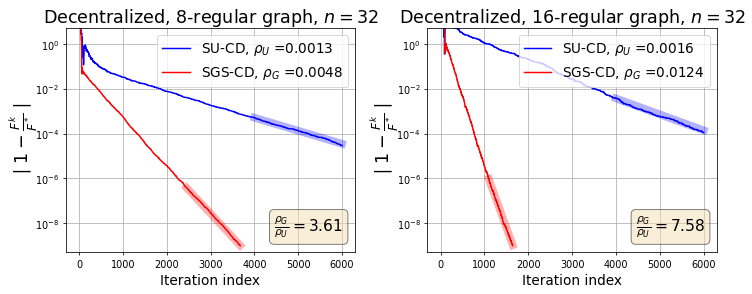

In [ ]:
fontsz = {'legends':14, 'axes':16, 'titles':18, 'suptitles':20}
figsz = (6*len(G_list), 4)
color = {'SU-CD':'blue', 'SGS-CD':'red'}
linestyle = {'SU-CD':'-', 'SGS-CD':'-'}
algo_labels = {'SU-CD':'SU-CD', 'SGS-CD':'SGS-CD'}


"""'''''' Rate estimation ''''''"""

plot_fitting = False
if plot_fitting:
    fig, ax = plt.subplots(1, len(G_list), figsize=figsz)
m_list = [[None for i in range(len(G_list))] for j in range(len(algos_to_run))]
b_list = [[None for i in range(len(G_list))] for j in range(len(algos_to_run))]
sel_idcs_list = [[None for i in range(len(G_list))] for j in range(len(algos_to_run))]
for idx_G in range(len(G_list)):
    dual_obj_vals = results_dual[idx_G]
    for idx_algo, algo in enumerate(algos_to_run):
        dual_vals = dual_obj_vals[algo]
        subopt = abs(1 - dual_vals/the_problem.analy_opt_obj_val)
        idcs_nz_subopt = np.argwhere(subopt > 0).flatten()
        non_zero_subopt = subopt[idcs_nz_subopt]
        third_steps = int(len(non_zero_subopt)/3)
        sel_idcs_subopt = idcs_nz_subopt[2*third_steps:]
        sel_subopt_vals = non_zero_subopt[2*third_steps:]
        m, b = np.polyfit(sel_idcs_subopt, np.log(sel_subopt_vals), 1)
        if plot_fitting:
            ax[idx_G].plot(sel_idcs_subopt, np.log(sel_subopt_vals), color=color[algo], linestyle=linestyle[algo], label=algo)
            ax[idx_G].plot( sel_idcs_subopt, m*sel_idcs_subopt+b, 'k--')

        m_list[idx_algo][idx_G] = m
        b_list[idx_algo][idx_G] = b
        sel_idcs_list[idx_algo][idx_G] = sel_idcs_subopt

rho_strs = {'SU-CD': r", $\rho_U$ =", 'SGS-CD': r", $\rho_G$ ="}


"""'''''' Plots ''''''"""

fig, ax = plt.subplots(1, len(G_list), figsize=figsz, dpi=70)

rate_list = [[None for i in range(len(G_list))] for j in range(len(algos_to_run))]
for idx_G in range(len(G_list)):
    dual_obj_vals = results_dual[idx_G]
    for idx_algo, algo in enumerate(algos_to_run):
        rate = 1 - np.exp(m_list[idx_algo][idx_G])
        suboptim = abs(1 - dual_obj_vals[algo]/the_problem.analy_opt_obj_val)
        ax[idx_G].plot(suboptim, color=color[algo], linestyle=linestyle[algo], label=algo_labels[algo] + rho_strs[algo] + "{:.4f}".format(rate) )
        support = sel_idcs_list[idx_algo][idx_G]
        subopt = suboptim[support[0]]
        support_2 = np.linspace(1, len(support), len(support))
        ax[idx_G].plot(support, (1-rate)**support_2 * subopt, color=color[algo], linewidth=8, alpha=0.3)
        rate_list[idx_algo][idx_G] = rate

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
for idx_G in range(len(G_list)):
    ax[idx_G].set_xlabel('Iteration index', fontsize=fontsz['axes']-2)
    ax[idx_G].set_ylabel(r'$ \mid 1 - \frac{F^k}{F^*} \mid $', fontsize=fontsz['axes']+2)
    ax[idx_G].get_ylim()
    ax[idx_G].set_ylim((5e-10,5))
    ax[idx_G].yaxis.set_label_coords(-0.09,0.5)
    ax[idx_G].grid()
    ax[idx_G].set_yscale("log")
    title_str = 'Decentralized, ' + str(deg_list[idx_G]) + '-regular graph, ' + r'$n = $' + str(n)
    ax[idx_G].set_title(title_str, fontsize=fontsz['titles'])
    ax[idx_G].legend(loc='upper right', fontsize=fontsz['legends'])

    textstr = r'$\frac{\rho_G}{\rho_U}=%.2f$' % (rate_list[1][idx_G]/rate_list[0][idx_G], )
    ax[idx_G].text(0.72, 0.17, textstr, transform=ax[idx_G].transAxes, fontsize=fontsz['legends']+2,
        verticalalignment='top', bbox=props) # bottom right

fig.subplots_adjust(
    left  = 0.125,  # the left side of the subplots of the figure
    right = 0.9,    # the right side of the subplots of the figure
    bottom = 0.05,   # the bottom of the subplots of the figure
    top = 0.85,      # the top of the subplots of the figure
    wspace = 0.25,   # the amount of width reserved for blank space between subplots
    hspace = 0.2)   # the amount of height reserved for white space between subplots
